# k-Nearest Neighbors Classification

This notebooks uses a simple kNN classifier that segmented the image detecting between damage and not damage.
Image segmentation follows the following propierties:
- Pixels from the same regions have similar greyscale of multivariate values.
- Adjacent pixels present in different regions have different values.

Also some of the hypterparaters of the kNN classifier to have in account are:
- Value of k. Number of neighbours.
- Measire of a distance (eg. Euclidean, Manhattan).
- If ussing Soft-kNN, way to combine the information of more than one observation
- Dominance of points (equally weighted or some points are dominating).

For this excercise we will use the euclidean distance and we will use cross-validation to find the best k. 
We will also try to compare how data preprocessing will affect the performance of the classifier.

### Set Up

In [1]:
# Common imports
import random
import numpy as np
from utils.data_utils import load_data

# Nice plots
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Keep notebook stable across the run
np.random.seed(42)

### Load data

In [7]:
filename = 'datasets/Deltas3.mat'

# This is a precaution: clean the data before start using it
try:
    del X_train, y_train
    del X_test, y_test
except:
    pass

# load_data
X_train, X_test, y_train, y_test = load_data(filename)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (2400, 51, 71)
Training labels shape:  (2400, 51, 71)
Test data shape:  (600, 51, 71)
Test labels shape:  (600, 51, 71)


### Exploring the data

In [3]:
#Some usefull functions to plot the images.
from utils.visualization_utils import plot_image


def plot_gray_image(image):
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')
    
def plot_color_image(image):
    plt.imshow(image.astype(np.unit8), interpolation='nearest')
    plt.axis('off')

def plot_image(image, color=False, reshape=False):
    if reshape:
        image = np.reshape(image, (51,71))
    if color:
        plot_color_image(image)
    else:
        plot_gray_image(image)

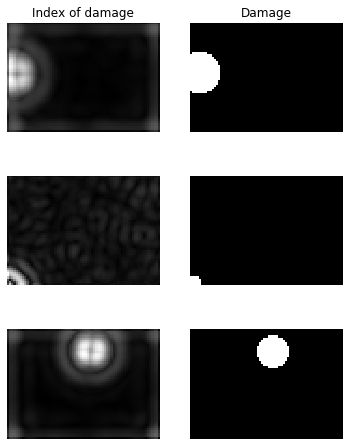

In [21]:
# Explore some data and their corresponding ground truth
from utils.visualization_utils import plot_image

some_images = np.random.randint(2400, size=(3))
plt.figure(figsize=(6, 8))
for i in range(1,4):
    plt.subplot(3,2,2*i-1)
    plot_image(X_train[some_images[i-1]])
    if i == 1:
        plt.title('Index of damage')
    plt.subplot(3,2,2*i)
    plot_image(y_train[some_images[i-1]])
    if i == 1:
        plt.title('Damage')
plt.show()

## Data Preprocessing 

In this first study we will just subsample the data for a quick run and vectorize the matrices.

In [23]:
# Preprocessing: Subsample the data for more efficient code execution in this exercise
num_test = 50
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [25]:
# Preprocessing: Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
y_train = np.reshape(y_train, (y_train.shape[0], -1))
y_test = np.reshape(y_test, (y_test.shape[0], -1))
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2400, 3621) (50, 3621)
(2400, 3621) (50, 3621)


In [33]:
# Preprocessing: Normalizing the data
from sklearn.preprocessing import Normalizer

# Create an instance of the normilizer
normalizer = Normalizer().fit(X_train)

# Fit the data
X_train = normalizer.transform(X_train)
X_test = normalizer.transform(X_test)

Now, the data is ready to be passed trought a classifier. We will try to use the kNN to classify whether a pixel in an index image is part of the damage zone or not. Just remember that this classifier consist in two steps:
- It calculates the distance between the analized pixel and the training data.
- Then, it choose the label comparing with the k nearest neighbors.

As we want an output the same size of the image we implemented the kNN in a little different way to the typical one. We calculate the distance pixel-wise so at the end of the process each pixel in a test image has a distance to all the pixels in the same position of the training data. As you can imagine, this process is computational expensive that's why we use such a small amount of test data.

Note that this is one of the main problems of kNN. Since the trainig function is a constant process, the predict function computation grows as we increase the test set.

In [34]:
from classifiers.k_nearest_neighbor import KNearestNeighbor
knn_clf = KNearestNeighbor()
knn_clf.train(X_train, y_train)

dists = knn_clf.predict(X_test)
dists.shape

(50, 2400, 3621)

In [35]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).

y_pred = knn_clf.predict_labels(dists, k=1)

10 EPOCH
20 EPOCH
30 EPOCH
40 EPOCH
50 EPOCH


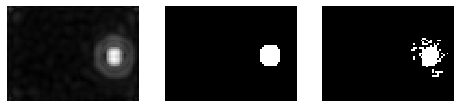

In [36]:
# Let's see the result of the 1-NN

some_image = 6
plt.figure(figsize=(8,12))
plt.subplot(1,3,1)
plot_image(np.reshape(X_test[some_image],(51,71)))
plt.subplot(1,3,2)
plot_image(np.reshape(y_test[some_image],(51,71)))
plt.subplot(1,3,3)
plot_image(np.reshape(y_pred[some_image],(51,71)))

To evaluate the performance of the classifier we will use the intersection over union value. This is defined by:
$$
IoU = \frac{TP}{FP+TP+FN}
$$

In [37]:
true_positive = np.sum(np.where(y_pred + y_test == 2, 1, 0), axis = 1)
false_positive = np.sum(np.where(y_pred - y_test == 1, 1, 0), axis = 1)
false_negative = np.sum(np.where(y_pred - y_test == -1, 1, 0), axis = 1)

iou = true_positive / (false_positive + true_positive + false_negative)
np.mean(iou)

0.4454083531843866

In [38]:
y_pred = knn_clf.predict_labels(dists, k=5)

10 EPOCH
20 EPOCH
30 EPOCH
40 EPOCH
50 EPOCH


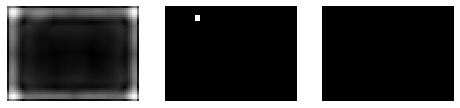

In [59]:
some_image = 9

plt.figure(figsize=(8,12))
plt.subplot(1,3,1)
plot_image(np.reshape(X_test[some_image],(51,71)))
plt.subplot(1,3,2)
plot_image(np.reshape(y_test[some_image],(51,71)))
plt.subplot(1,3,3)
plot_image(np.reshape(y_pred[some_image],(51,71)))

In [40]:
true_positive = np.sum(np.where(y_pred + y_test == 2, 1, 0), axis = 1)
false_positive = np.sum(np.where(y_pred - y_test == 1, 1, 0), axis = 1)
false_negative = np.sum(np.where(y_pred - y_test == -1, 1, 0), axis = 1)

iou = true_positive / (false_positive + true_positive + false_negative)
np.mean(iou)

0.5245048696511984

## Fine-Tuning the Model
To get the maximun score of the model we will need to choose the correct hyperparameters. In this classifier the most important hyperparameter is the number of neighbors with whom the model will compare the labels (k).

For this case we will use cross-validation ussing 5 different folds.

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}

num_test_fold = X_train_folds[0].shape[0]
for k_value in k_choices:
    k_list = []
    for fold_index in range(num_folds): 
        # Train classifier
        val_set = X_train_folds.pop(fold_index)
        val_lbl = y_train_folds.pop(fold_index)
        X_fold = np.vstack(X_train_folds)
        y_fold = np.hstack(y_train_folds)
        classifier = KNearestNeighbor()
        classifier.train(X_fold, y_fold)
        
        # Calculate the accuracy
        y_test_pred = classifier.predict(val_set, k=k_value)
        true_positive = np.sum(np.where(y_pred + y_test == 2, 1, 0), axis = 1)
        false_positive = np.sum(np.where(y_pred - y_test == 1, 1, 0), axis = 1)
        false_negative = np.sum(np.where(y_pred - y_test == -1, 1, 0), axis = 1)

        iou = np.mean(true_positive / (false_positive + true_positive + false_negative))   
        k_list.append(iou)
        
        # Restore the varables
        X_train_folds = np.array_split(X_train, num_folds)
        y_train_folds = np.array_split(y_train, num_folds)
        
    k_to_accuracies[k_value] = k_list
    
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [54]:
import pandas as pd

In [55]:
results_df = pd.DataFrame(
    [(true_positive[i], false_positive[i], false_negative[i])
     for i in range(len(false_negative))],
    columns=['true_positive', 'false_positive', 'false_negative'])

In [60]:
results_df['precision'] = results_df['true_positive']/(results_df['true_positive']+results_df['false_positive'])
results_df['recall'] = results_df['true_positive']/(results_df['true_positive']+results_df['false_negative'])

In [62]:
results_df['precision'].mean()

0.7587402204996166

In [63]:
results_df['recall'].mean()

0.6076917865113795

In [61]:
results_df

,true_positive,false_positive,false_negative,precision,recall
0,115,3,121,0.974576,0.487288
1,149,9,28,0.943038,0.841808
2,36,12,1,0.750000,0.972973
3,42,5,22,0.893617,0.656250
4,23,22,2,0.511111,0.920000
5,5,7,4,0.416667,0.555556
6,79,24,30,0.766990,0.724771
7,139,6,54,0.958621,0.720207
8,4,1,1,0.800000,0.800000
9,0,0,9,NaN,0.000000


In [52]:
print('false negative: ' , false_negative)
print('false positive: ', false_positive)
print('true positive:', true_positive)

false negative:  [121  28   1  22   2   4  30  54   1   9  25  11   7  58   9  18  19  10
  13  44  10 101  59  27   5  11  25   5  30  31   5  21  60  16  56  67
  10  66  19 100  25   5  18 126   3  61   5   1   4  12]
false positive:  [ 3  9 12  5 22  7 24  6  1  0  1 10  3  0  0 33  6  4  1  6 60 13  5 57
  0 11 10  0  7  3  0  6  6 25  2  7  6  3  8  5  6  3 19  7  8  1  4 26
 17  5]
true positive: [115 149  36  42  23   5  79 139   4   0 138  58   2 136   0  51 121  91
   0 106  25  95 118  23   0  58 168   0 147 162   0 111 103  97 140  89
   3 141 158 175 114   0  57 149  66 192   0  68  14  13]
